<a href="https://colab.research.google.com/github/yfb2022/STAT_DL_INTRO/blob/main/6_4_sequence_processing_with_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.15.0'

# Sequence processing with convnets

## Implementing a 1D convnet

layer_conv_1d() 통해 Keras에서 1D 컨브넷을 사용

layer_conv_2d() 모양이 있는 3D 텐서를 입력으로 사용 : (samples, time, features) and 비슷한 모양의 3D 텐서를 반환. 컨볼루션 창은 입력 텐서의 두 번째 축인 시간 축의 1D 창

간단한 2계층 1D 컨브넷을 구축하고 이를 이미 익숙한 IMDB 감정 분류 작업에 적용해 보겠습니다. 참고로 이는 데이터를 획득하고 전처리하는 코드입니다.


In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)



1D 컨브넷은 5장에서 사용한 2D 컨브넷과 동일한 방식으로 구성됩니다. 이는 3D 출력을 2D 출력으로 바꾸는 글로벌 풀링 레이어 또는 Flattn로 끝나는 layer_conv_1d()  layer_max_pooling_1d() 스택으로 구성됩니다 분류 또는 회귀를 위해 모델에 하나 이상의 밀집 레이어를 추가합니다.

그러나 한 가지 차이점은 1D 컨볼루션 창을 사용하면 더 큰 컨볼루션 창을 사용할 수 있다는 것입니다. 2D 컨볼루션 레이어의 경우 3 × 3 컨볼루션 창에는 3 * 3 = 9개의 특징 벡터가 포함됩니다. 그러나 1D 컨볼루션 레이어의 경우 크기 3의 컨볼루션 창에는 3개의 특징 벡터만 포함됩니다. 따라서 크기 7 또는 9의 1D 컨볼루션 창을 쉽게 감당할 수 있습니다.

이것은 IMDB 데이터 세트에 대한 1D 컨브넷의 예입니다.

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 3

Epoch 1/10
157/157 [==============================] - 77s 483ms/step - loss: 0.5904 - acc: 0.6788 - val_loss: 0.5848 - val_acc: 0.7938
Epoch 2/10
157/157 [==============================] - 66s 419ms/step - loss: 0.3950 - acc: 0.8651 - val_loss: 0.4041 - val_acc: 0.8700
Epoch 3/10
157/157 [==============================] - 69s 439ms/step - loss: 0.3068 - acc: 0.9086 - val_loss: 1.1914 - val_acc: 0.7498
Epoch 4/10
157/157 [==============================] - 70s 448ms/step - loss: 0.2407 - acc: 0.9315 - val_loss: 0.6886 - val_acc: 0.8580
Epoch 5/10
157/157 [==============================] - 68s 431ms/step - loss: 0.1944 - acc: 0.9553 - val_loss: 0.5590 - val_acc: 0.8752
Epoch 6/10
157/157 [==============================] - 65s 416ms/step - loss: 0.1451 - acc: 0.9727 - val_loss: 0.6998 - val_acc: 0.8772
Epoch 7/10
157/157 [==============================] - 67s 427ms/step - loss: 0.1160 - acc: 0.9826 - val_loss: 0.9037 - val_acc: 0.8638
Epoch 8/10
157/157 [==============================] - 6

훈련 및 검증 결과는 다음과 같습니다. 검증 정확도는 이전 두 섹션에서 사용한 LSTM보다 다소 낮지만 CPU와 GPU 모두에서 런타임이 더 빠릅니다(비록 정확한 속도 향상은 정확한 구성에 따라 크게 달라질 수 있음). 그 시점에서 우리는 이 모델을 적절한 에포크 수(8) 동안 재교육하고 테스트 세트에서 실행할 수 있습니다. 이는 1D 컨브넷이 단어 수준 감정 분류 작업에서 순환 네트워크에 대한 빠르고 저렴한 대안을 제공할 수 있다는 설득력 있는 시연입니다.

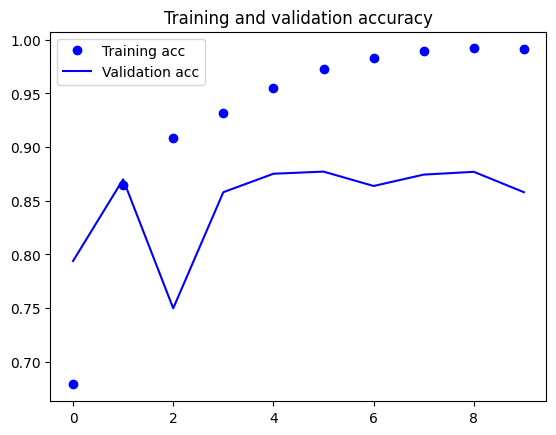

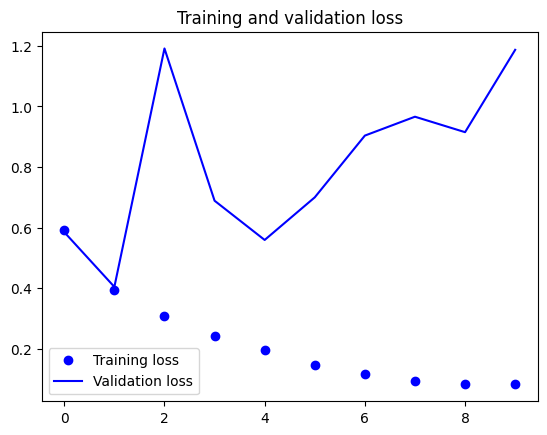

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Combining CNNs and RNNs to process long sequences

1D 컨볼루션은 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 시간 단계의 순서(로컬 스케일, 컨볼루션 창의 크기)에 민감하지 않습니다. 물론 장기적인 패턴을 인식할 수 있으려면 많은 컨볼루션 레이어와 풀링 레이어를 쌓아 원래 입력의 긴 덩어리를 "볼" 수 있는 상위 레이어를 만들 수 있습니다. 하지만 이는 여전히 순서 민감성 유도하기에는 상당히 약한 방법입니다. 이러한 약점을 입증하는 한 가지 방법은 이전 섹션의 온도 예측 문제에 대해 1D 컨브넷을 시도하는 것입니다. 여기서 순서 민감도는 좋은 예측을 생성하는 데 중요했습니다.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -o /content/drive/MyDrive/mpi_roof.zip

Archive:  /content/drive/MyDrive/mpi_roof.zip
  inflating: mpi_roof.csv            


In [14]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

data_dir = '/content/'
fname = os.path.join(data_dir, 'mpi_roof.csv')

f = open(fname, encoding='latin-1')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
## CP
float_data = np.zeros((len(lines), len(header) - 1))
# data <- data.matrix(data[,-1])
for i, line in enumerate(lines[:-1]):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
# mean <- apply(train_data, 2, mean)
# std <- apply(train_data, 2, sd)
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#    for (j in 1:length(rows)) {
#       indices <- seq(rows[[j]] - lookback, rows[[j]],
#                      length.out = dim(samples)[[2]])
#       samples[j,,] <- data[indices,]
#       targets[[j]] <- data[rows[[j]] + delay,2]
#     }

#     list(samples, targets)
#   }
# }

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=10000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=10001,
                    max_index=15000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=15001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (15000 - 10001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 15001 - lookback) // batch_size

In [12]:
len(float_data)

24125

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


<ipython-input-15-1a1ca25d2ec3>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 27s 52ms/step - loss: 0.2868 - val_loss: 1.3140
Epoch 2/20
500/500 [==============================] - 26s 52ms/step - loss: 0.2082 - val_loss: 1.3155
Epoch 3/20
500/500 [==============================] - 26s 52ms/step - loss: 0.1739 - val_loss: 0.9090
Epoch 4/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1491 - val_loss: 0.7571
Epoch 5/20
500/500 [==============================] - 28s 57ms/step - loss: 0.1361 - val_loss: 0.8336
Epoch 6/20
500/500 [==============================] - 25s 50ms/step - loss: 0.1255 - val_loss: 0.7336
Epoch 7/20
500/500 [==============================] - 26s 52ms/step - loss: 0.1179 - val_loss: 0.6837
Epoch 8/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1110 - val_loss: 0.6909
Epoch 9/20
500/500 [==============================] - 26s 51ms/step - loss: 0.1054 - val_loss: 0.7013
Epoch 10/20
500/500 [==============================] - 26s 52ms/step - loss: 0.1008 - val_los

Here are our training and validation Mean Absolute Errors:

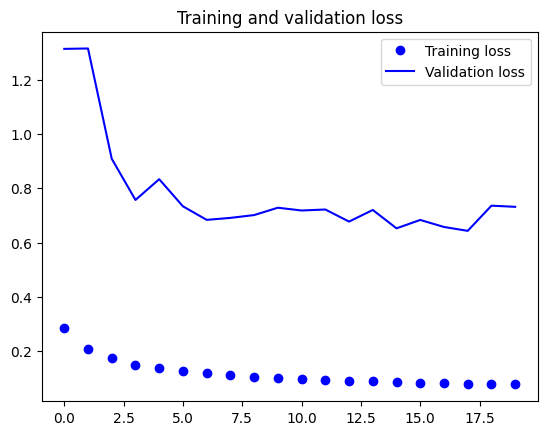

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 MAE는 0.40초로 유지됩니다. 작은 컨브넷을 사용하면 상식적인 기준선도 이길 수 없습니다. 다시 말하지만, 이는 컨브넷이 입력 시계열의 어느 곳에서나 패턴을 찾고 자신이 보는 패턴의 시간적 위치(시작 방향, 끝 방향 등)에 대한 지식이 없기 때문입니다.

이 특정 예측 문제의 경우 최신 데이터 포인트는 이전 데이터 포인트와 다르게 해석되어야 하기 때문에 컨브넷은 의미 있는 결과를 생성하지 못합니다. 컨브넷의 이러한 제한은 IMDB 데이터에서는 문제가 되지 않습니다. 왜냐하면 긍정적이거나 부정적인 감정과 관련된 키워드 패턴은 입력 문장에서 발견되는 위치와 관계없이 유익하기 때문입니다.

컨브넷의 속도와 가벼움을 RNN의 순서 민감성과 결합하는 한 가지 전략은 RNN 이전의 전처리 단계로 1D 컨브넷을 사용하는 것입니다(그림 6.30 참조). 이는 수천 단계의 시퀀스와 같이 너무 길어 RNN으로 현실적으로 처리할 수 없는 시퀀스를 처리할 때 특히 유용합니다. 컨브넷은 긴 입력 시퀀스를 더 높은 수준의 기능으로 구성된 훨씬 짧은(다운샘플링된) 시퀀스로 변환합니다. 이렇게 추출된 특징의 시퀀스는 네트워크의 RNN 부분에 대한 입력이 됩니다.

이 기술은 연구 논문이나 실제 응용 분야에서 자주 볼 수 없습니다. 아마도 잘 알려져 있지 않기 때문일 것입니다. 그것은 효과적이며 더 일반적이어야합니다. 온도 예측 데이터 세트에서 이를 시도해 보겠습니다. 이 전략을 사용하면 훨씬 더 긴 시퀀스를 조작할 수 있으므로 더 오래 전의 데이터를 보거나(데이터 생성기의 매개변수를 늘려 lookback) 고해상도 시계열을 볼 수 있습니다( step생성기의 매개변수를 줄여서). 여기에서는 임의적으로 절반 크기의 를 사용하여 step시계열의 길이가 두 배로 늘어나며 날씨 데이터는 30분당 1포인트의 속도로 샘플링됩니다. 이 예에서는 generator앞서 정의한 함수를 재사용합니다.


이 기술은 연구 논문이나 실제 응용 분야에서 자주 볼 수 없습니다. 아마도 잘 알려져 있지 않기 때문일 것입니다. 그것은 효과적이며 더 일반적이어야합니다. 온도 예측 데이터 세트에서 이를 시도해 보겠습니다. 이 전략을 사용하면 훨씬 더 긴 시퀀스를 조작할 수 있으므로 더 오래 전의 데이터를 보거나(데이터 생성기의 매개변수를 늘려 lookback) 고해상도 시계열을 볼 수 있습니다( step생성기의 매개변수를 줄여서). 여기에서는 임의적으로 절반 크기의 를 사용하여 step시계열의 길이가 두 배로 늘어나며 날씨 데이터는 30분당 1포인트의 속도로 샘플링됩니다. 이 예에서는 generator앞서 정의한 함수를 재사용합니다.



In [17]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=10000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=10001,
                    max_index=15000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=15001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (15000 - 10001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 15001 - lookback) // batch_size

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, None, 32)          3392      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14913 (58.25 KB)
Trainable params: 14913 (58.25 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

<ipython-input-18-b3d2efc2f7d8>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 86s 162ms/step - loss: 0.2680 - val_loss: 0.7759
Epoch 2/20
500/500 [==============================] - 79s 157ms/step - loss: 0.1590 - val_loss: 0.8070
Epoch 3/20
 81/500 [===>..........................] - ETA: 59s - loss: 0.1325

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

유효성 검사 손실로 판단하면 이 설정은 정규화된 GRU만 사용하는 것만큼 좋지는 않지만 훨씬 빠릅니다. 두 배 더 많은 데이터를 조사하고 있는데, 이 경우에는 큰 도움이 되지 않는 것처럼 보이지만 다른 데이터 세트에는 중요할 수 있습니다.

## Wrapping up

2D 컨브넷이 2D 공간의 시각적 패턴을 처리하는 데 효과적인 것처럼, 1D 컨브넷도 시간 패턴을 처리하는 데 효과적입니다. 이는 일부 문제, 특히 자연어 처리 작업에 대해 RNN에 대한 더 빠른 대안을 제공합니다.

일반적으로 1D 컨브넷은 컴퓨터 비전 세계의 2D 컨브넷과 매우 유사하게 구조화됩니다. 이는 layer_conv_1d()및 layer_max_pooling_1d()스택으로 consst 글로벌 풀링 작업 또는 평면화 작업으로 끝납니다.

RNN은 매우 긴 시퀀스를 처리하는 데 매우 비용이 많이 들지만 1D 컨브넷은 저렴하기 때문에 RNN 전 전처리 단계로 1D 컨브넷을 사용하여 시퀀스를 단축하고 RNN이 처리할 유용한 표현을 추출하는 것이 좋습니다.